In [1158]:
"""
Created on Tuesday 21 Sep 2023
Author: ZAW
"""
##import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
import pickle
import seaborn as sns
from scipy.stats import pearsonr
import shap
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [1159]:
import matplotlib.pyplot as plt# Set the default text font size
plt.rc('font', size=16)# Set the axes title font size
plt.rc('axes', titlesize=16)# Set the axes labels font size
plt.rc('axes', labelsize=16)# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)# Set the legend font size
plt.rc('legend', fontsize=16)# Set the font size of the figure title
plt.rc('figure', titlesize=20)

### Read the dataset

In [1170]:
df = pd.read_excel('data/list_of_detected_peak_pairs.xlsx',skiprows=2)

In [1171]:
# Column labels
df.columns

Index(['No', 'RT (s)', 'Normalized RT (s)', 'm/z_light', 'm/z_heavy',
       'Neutral Mass (Da)', 'Intensity', 'nCharge', 'nTag', 'Unnamed: 9',
       'NovaMT Library No.', 'External Identifier', 'Compound',
       'Mass Error (ppm)', 'RT Error (s)', 'NovaMT Library No..1',
       'External Identifier.1', 'Compound.1', 'Mass Error (ppm).1',
       'RT Error (s).1', 'Zero-reaction', 'One-reaction', 'Two-reaction',
       'Unnamed: 23', 'DR', 'DR.1', 'DR.2', 'DR.3', 'DR.4', 'DR.5', 'DR.6',
       'DR.7', 'No DR', 'DR.8', 'DR.9', 'No DR.1', 'DR.10', 'DR.11', 'DR.12',
       'DR.13', 'DR.14', 'DR.15', 'DR.16', 'No DR.2', 'DR.17', 'DR.18',
       'DR.19', 'DR.20', 'No DR.3', 'No DR.4', 'DR.21', 'DR.22', 'DR.23',
       'DR.24', 'No DR.5', 'No DR.6', 'No DR.7', 'No DR.8', 'No DR.9',
       'No DR.10', 'No DR.11', 'No DR.12', 'No DR.13', 'No DR.14', 'No DR.15',
       'No DR.16', 'No DR.17', 'No DR.18', 'No DR.19', 'No DR.20', 'No DR.21',
       'No DR.22', 'No DR.23', 'No DR.24', 'No DR.25',

## Data cleaning

#### Extract the relevant columns from the dataframe

In [1172]:
columns = ['Normalized RT (s)','m/z_light', 'm/z_heavy',
       'Neutral Mass (Da)', 'Intensity','Compound','Compound.1','DR', 'DR.1', 'DR.2', 'DR.3', 'DR.4', 'DR.5', 'DR.6',
       'DR.7', 'No DR', 'DR.8', 'DR.9', 'No DR.1', 'DR.10', 'DR.11', 'DR.12',
       'DR.13', 'DR.14', 'DR.15', 'DR.16', 'No DR.2', 'DR.17', 'DR.18',
       'DR.19', 'DR.20', 'No DR.3', 'No DR.4', 'DR.21', 'DR.22', 'DR.23',
       'DR.24', 'No DR.5', 'No DR.6', 'No DR.7', 'No DR.8', 'No DR.9',
       'No DR.10', 'No DR.11', 'No DR.12', 'No DR.13', 'No DR.14', 'No DR.15',
       'No DR.16', 'No DR.17', 'No DR.18', 'No DR.19', 'No DR.20', 'No DR.21',
       'No DR.22', 'No DR.23', 'No DR.24', 'No DR.25', 'No DR.26', 'No DR.27',
       'No DR.28', 'No DR.29']
df = df[columns]

In [1173]:
#Drop the empty rows(i.e Nan): only drop row if both tier 1 and tier 2 are empty
df.drop(df[(df['Compound'].isna() | (df['Compound'] == '')) & (df['Compound.1'].isna() | (df['Compound.1'] == ''))].index, inplace=True)

In [1174]:
#iterate row over tier 1 and repalce NaN with values from tier2 column(merge tier 1 and tier2)
for index, row in df.iterrows():
    if pd.isnull(row['Compound']):
        df.at[index, 'Compound'] = row['Compound.1']

In [1175]:
# drop the tier 2 column
df = df.drop('Compound.1', axis=1)

In [1176]:
df.columns

Index(['Normalized RT (s)', 'm/z_light', 'm/z_heavy', 'Neutral Mass (Da)',
       'Intensity', 'Compound', 'DR', 'DR.1', 'DR.2', 'DR.3', 'DR.4', 'DR.5',
       'DR.6', 'DR.7', 'No DR', 'DR.8', 'DR.9', 'No DR.1', 'DR.10', 'DR.11',
       'DR.12', 'DR.13', 'DR.14', 'DR.15', 'DR.16', 'No DR.2', 'DR.17',
       'DR.18', 'DR.19', 'DR.20', 'No DR.3', 'No DR.4', 'DR.21', 'DR.22',
       'DR.23', 'DR.24', 'No DR.5', 'No DR.6', 'No DR.7', 'No DR.8', 'No DR.9',
       'No DR.10', 'No DR.11', 'No DR.12', 'No DR.13', 'No DR.14', 'No DR.15',
       'No DR.16', 'No DR.17', 'No DR.18', 'No DR.19', 'No DR.20', 'No DR.21',
       'No DR.22', 'No DR.23', 'No DR.24', 'No DR.25', 'No DR.26', 'No DR.27',
       'No DR.28', 'No DR.29'],
      dtype='object')

In [1177]:
df

,Normalized RT (s),m/z_light,m/z_heavy,Neutral Mass (Da),Intensity,Compound,DR,DR.1,DR.2,DR.3,...,No DR.20,No DR.21,No DR.22,No DR.23,No DR.24,No DR.25,No DR.26,No DR.27,No DR.28,No DR.29
18,386.3,398.1376,400.1438,150.0524,1449.809490,L-Arabinose,0.8630,0.7320,0.8620,0.7700,...,0.803,0.963,1.082,0.830,0.852,0.861,0.702,0.891,1.031,0.800
19,392.5,307.1225,309.1285,59.0373,1152.039064,Aminoacetaldehyde,1.1760,1.7130,0.8350,1.0260,...,0.438,0.619,0.669,0.790,0.571,0.729,0.585,0.522,0.664,0.746
41,581.4,394.1433,396.1498,146.0580,1150.063645,(R)-4-Dehydropantoic acid,0.8670,0.8920,0.8880,0.9790,...,0.849,0.963,0.942,1.017,0.902,0.917,0.902,0.846,0.999,0.981
46,623.4,394.1433,396.1496,146.0581,1303.804362,3-Hydroxy-5-oxohexanoic acid,0.9450,0.9830,0.9370,0.9890,...,0.885,0.961,0.961,1.044,0.876,0.909,0.995,0.848,0.992,1.006
49,683.3,292.1114,294.1179,44.0262,1113.644708,Acetaldehyde,0.9300,0.9280,0.9610,1.0140,...,0.821,0.944,0.949,1.030,0.861,0.882,0.889,0.764,0.944,0.945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,1034.5,402.1010,404.1073,168.0426,1044.374071,Vanillic acid,0.9866,0.2761,0.8764,0.1797,...,1.133,1.973,1.061,0.602,1.243,0.754,1.723,1.017,1.500,0.780
804,1048.1,372.0905,374.0971,138.0322,1314.406927,4-Hydroxybenzoic acid,0.5708,1.9410,1.0534,1.6530,...,1.364,2.177,1.093,0.911,1.785,0.689,1.439,1.161,0.876,0.750
805,1048.3,307.1129,309.1196,146.1091,5248.849898,Lysine (2 tags 2 charges),0.6710,0.7590,0.4060,0.8890,...,1.779,0.860,1.121,0.761,1.678,0.581,0.882,1.179,0.644,0.949
809,1080.0,307.1479,309.1547,73.0896,1559.591727,Diethylamine,0.7140,1.0360,1.0080,0.6750,...,0.587,0.824,0.964,0.835,0.562,0.651,0.774,0.877,0.985,0.804


In [1178]:
#transpose the DataFrame such that the 'Compound' column becomes the column index 
df = df.set_index('Compound').T

In [1179]:
df.head(10)

Compound,L-Arabinose,Aminoacetaldehyde,(R)-4-Dehydropantoic acid,3-Hydroxy-5-oxohexanoic acid,Acetaldehyde,3-Hydroxypropanal,Dihydrophloroglucinol,2-Oxovaleric acid,Adipate semialdehyde,Acrolein,...,5-Aminopentanal,Theophylline,"cis,cis-4-Hydroxymuconic semialdehyde",Ornithine (2 tags 2 charges),2-Hydroxymuconate semialdehyde,Vanillic acid,4-Hydroxybenzoic acid,Lysine (2 tags 2 charges),Diethylamine,Histidine
Normalized RT (s),386.30000,392.500000,581.400000,623.400000,683.300000,687.800000,717.000000,731.400000,765.100000,774.800000,...,824.500000,918.600000,921.900000,975.900000,1009.100000,1034.500000,1048.100000,1048.300000,1080.000000,1112.000000
m/z_light,398.13760,307.122500,394.143300,394.143300,292.111400,322.122300,376.132600,364.132500,378.147000,304.111600,...,335.143000,414.123000,376.085600,300.105100,376.085400,402.101000,372.090500,307.112900,307.147900,389.128500
m/z_heavy,400.14380,309.128500,396.149800,396.149600,294.117900,324.128800,378.138700,366.138700,380.154800,306.120100,...,337.149400,416.129400,378.091600,302.111900,378.091800,404.107300,374.097100,309.119600,309.154700,391.134900
Neutral Mass (Da),150.05240,59.037300,146.058000,146.058100,44.026200,74.037100,128.047400,116.047300,130.061800,56.026400,...,101.084700,180.064700,142.027300,132.093400,142.027100,168.042600,138.032200,146.109100,73.089600,155.070100
Intensity,1449.80949,1152.039064,1150.063645,1303.804362,1113.644708,1735.581226,1021.290947,1113.653816,1047.512093,1334.650335,...,21583.925319,1139.529581,1151.586552,5584.712865,1087.320634,1044.374071,1314.406927,5248.849898,1559.591727,5920.234434
DR,0.86300,1.176000,0.867000,0.945000,0.930000,0.947000,1.557000,1.083000,0.996000,0.437000,...,1.005000,0.955100,1.224900,0.477000,0.657900,0.986600,0.570800,0.671000,0.714000,0.612000
DR.1,0.73200,1.713000,0.892000,0.983000,0.928000,0.908000,1.292000,0.979000,0.968000,0.458000,...,0.994000,0.992000,0.151300,0.497000,1.084900,0.276100,1.941000,0.759000,1.036000,0.446000
DR.2,0.86200,0.835000,0.888000,0.937000,0.961000,0.952000,1.347000,1.083000,1.005000,0.876000,...,0.329000,1.030500,0.582900,0.283500,0.917900,0.876400,1.053400,0.406000,1.008000,0.098800
DR.3,0.77000,1.026000,0.979000,0.989000,1.014000,1.040000,1.749000,0.983000,1.006000,0.626000,...,1.110000,0.771800,0.920000,1.142000,0.850000,0.179700,1.653000,0.889000,0.675000,0.781000
DR.4,0.81200,0.848000,0.956000,0.960000,0.973000,0.968000,1.768000,0.955000,0.994000,0.472000,...,1.408000,0.977000,1.253100,0.612000,0.894200,0.227500,1.606000,1.247000,1.263000,0.731000


In [1180]:
# Drop the top 5 row
df = df.drop(df.index[:5])

In [1181]:
#Rename the 'Compound' column to 'SampleID'
df = df.rename_axis('SampleID', axis='columns')

In [1182]:
# add class column for classification
df['Class'] = df.index.map(lambda x: 'DR' if x.startswith('DR') else 'No DR')


In [1183]:
# Rseset index
df.reset_index(drop=True, inplace=True)

In [1184]:
df.head(10)

SampleID,L-Arabinose,Aminoacetaldehyde,(R)-4-Dehydropantoic acid,3-Hydroxy-5-oxohexanoic acid,Acetaldehyde,3-Hydroxypropanal,Dihydrophloroglucinol,2-Oxovaleric acid,Adipate semialdehyde,Acrolein,...,Theophylline,"cis,cis-4-Hydroxymuconic semialdehyde",Ornithine (2 tags 2 charges),2-Hydroxymuconate semialdehyde,Vanillic acid,4-Hydroxybenzoic acid,Lysine (2 tags 2 charges),Diethylamine,Histidine,Class
0,0.863,1.176,0.867,0.945,0.930,0.947,1.557,1.083,0.996,0.437,...,0.9551,1.2249,0.4770,0.6579,0.9866,0.5708,0.671,0.7140,0.6120,DR
1,0.732,1.713,0.892,0.983,0.928,0.908,1.292,0.979,0.968,0.458,...,0.9920,0.1513,0.4970,1.0849,0.2761,1.9410,0.759,1.0360,0.4460,DR
2,0.862,0.835,0.888,0.937,0.961,0.952,1.347,1.083,1.005,0.876,...,1.0305,0.5829,0.2835,0.9179,0.8764,1.0534,0.406,1.0080,0.0988,DR
3,0.770,1.026,0.979,0.989,1.014,1.040,1.749,0.983,1.006,0.626,...,0.7718,0.9200,1.1420,0.8500,0.1797,1.6530,0.889,0.6750,0.7810,DR
4,0.812,0.848,0.956,0.960,0.973,0.968,1.768,0.955,0.994,0.472,...,0.9770,1.2531,0.6120,0.8942,0.2275,1.6060,1.247,1.2630,0.7310,DR
5,1.013,0.809,0.951,1.058,0.980,1.034,1.868,0.972,1.020,0.772,...,1.5270,1.5673,0.6320,1.3220,1.2623,0.7303,0.363,0.6041,0.3540,DR
6,0.537,0.983,0.876,0.864,0.826,0.816,1.265,0.706,0.867,0.403,...,1.6670,2.1380,0.5570,1.8035,1.7220,0.9963,0.528,1.3800,0.2420,DR
7,1.022,1.599,0.920,0.975,0.968,0.970,1.661,0.997,0.988,0.415,...,1.2600,1.1951,0.3940,0.8528,0.9626,1.6832,0.448,0.7100,0.3690,DR
8,1.490,0.603,0.902,0.953,0.928,0.932,1.635,0.920,0.971,0.811,...,1.4690,0.1315,0.6220,1.1780,1.0639,1.8470,1.005,0.6650,1.4300,No DR
9,1.315,0.758,0.974,0.977,0.948,0.936,1.676,0.930,1.035,0.837,...,0.7890,0.1326,0.4080,1.2530,0.2418,1.0410,1.102,0.6270,0.7090,DR


In [1185]:
# Drop duplicate columns
df = df.loc[:,~df.columns.duplicated()]

In [1186]:
df.head()

SampleID,L-Arabinose,Aminoacetaldehyde,(R)-4-Dehydropantoic acid,3-Hydroxy-5-oxohexanoic acid,Acetaldehyde,3-Hydroxypropanal,Dihydrophloroglucinol,2-Oxovaleric acid,Adipate semialdehyde,Acrolein,...,Theophylline,"cis,cis-4-Hydroxymuconic semialdehyde",Ornithine (2 tags 2 charges),2-Hydroxymuconate semialdehyde,Vanillic acid,4-Hydroxybenzoic acid,Lysine (2 tags 2 charges),Diethylamine,Histidine,Class
0,0.863,1.176,0.867,0.945,0.930,0.947,1.557,1.083,0.996,0.437,...,0.9551,1.2249,0.4770,0.6579,0.9866,0.5708,0.671,0.714,0.6120,DR
1,0.732,1.713,0.892,0.983,0.928,0.908,1.292,0.979,0.968,0.458,...,0.9920,0.1513,0.4970,1.0849,0.2761,1.9410,0.759,1.036,0.4460,DR
2,0.862,0.835,0.888,0.937,0.961,0.952,1.347,1.083,1.005,0.876,...,1.0305,0.5829,0.2835,0.9179,0.8764,1.0534,0.406,1.008,0.0988,DR
3,0.770,1.026,0.979,0.989,1.014,1.040,1.749,0.983,1.006,0.626,...,0.7718,0.9200,1.1420,0.8500,0.1797,1.6530,0.889,0.675,0.7810,DR
4,0.812,0.848,0.956,0.960,0.973,0.968,1.768,0.955,0.994,0.472,...,0.9770,1.2531,0.6120,0.8942,0.2275,1.6060,1.247,1.263,0.7310,DR


# Plot volcano plots. 

In [1187]:
# Select the metabolite columns and class label column
metabolite_columns = df.columns[0:-1] # Exclude the first column ('Sample ID') and the last column ('Class Label')
class_label_col = 'Class'

# Split the data into two groups based on the class labels
group1 = df[df[class_label_col] == 'DR']
group2 = df[df[class_label_col] == 'No DR']

In [1188]:
# Calculate the fold change
fold_change = np.log2(group2[metabolite_columns].mean() / group1[metabolite_columns].mean())

In [1189]:
# Perform statistical test (e.g., t-test) to calculate the p-values for each metabolite
_, p_values = ttest_ind(group1[metabolite_columns], group2[metabolite_columns])

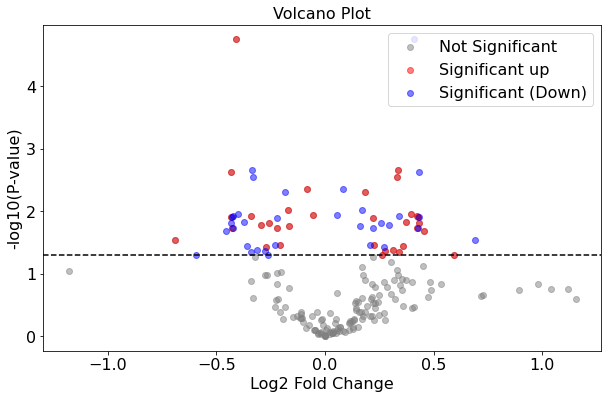

In [1190]:
# Create the volcano plot
significance_threshold = 0.05

plt.figure(figsize=(10, 6))
plt.scatter(fold_change, -np.log10(p_values), color='gray', alpha=0.5, label='Not Significant')
plt.scatter(fold_change[p_values < significance_threshold], -np.log10(p_values[p_values < significance_threshold]), color='red', alpha=0.5, label='Significant up')
plt.scatter(fold_change[p_values < significance_threshold] * -1, -np.log10(p_values[p_values < significance_threshold]), color='blue', alpha=0.5, label='Significant (Down)')
plt.axhline(-np.log10(significance_threshold), color='black', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot')
plt.legend()
plt.show()

# ML models

#### Transform the Data

In [909]:
x = df.iloc[:, :167]
y = df.iloc[:,-1]


In [910]:
# Reshape the data
x = x.values
x = x.reshape((x.shape[0], -1)) 

In [912]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=23)

### PLS-DA for classificaiton

In [963]:
# Set up the PLS-DA classifier
pls = PLSRegression(n_components=2)
pls.fit(x, y)
x_pls = pls.transform(x)

lda = LinearDiscriminantAnalysis()
model = lda.fit(x_pls, y)

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x_pls, y, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.93
Permutation test p-value: 0.0099


### Fine-tune model(PLS-DA)

In [933]:
# Set up the PLS-DA classifier
pls = PLSRegression(n_components=2)
pls.fit(x, y)
x_pls = pls.transform(x)

lda = LinearDiscriminantAnalysis()
model = lda.fit(x_pls, y)

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'n_components': [1, 2, 3, 4, 5],
}

# Define the scoring metric
scorer = make_scorer(roc_auc_score)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=cv, n_jobs=1)
grid_search.fit(x_pls, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
LinearDiscriminantAnalysis(n_components=1)
Best Score: 0.86
Best Parameters:
{'n_components': 1}


### VIP score plot

In [646]:
def calculate_vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

# Load the model from disk
filename = 'models/finalized_pls_da_model.sav'
best_model = pickle.load(open(filename, 'rb'))

# Calculate VIP scores
vip_scores = calculate_vip(best_model)

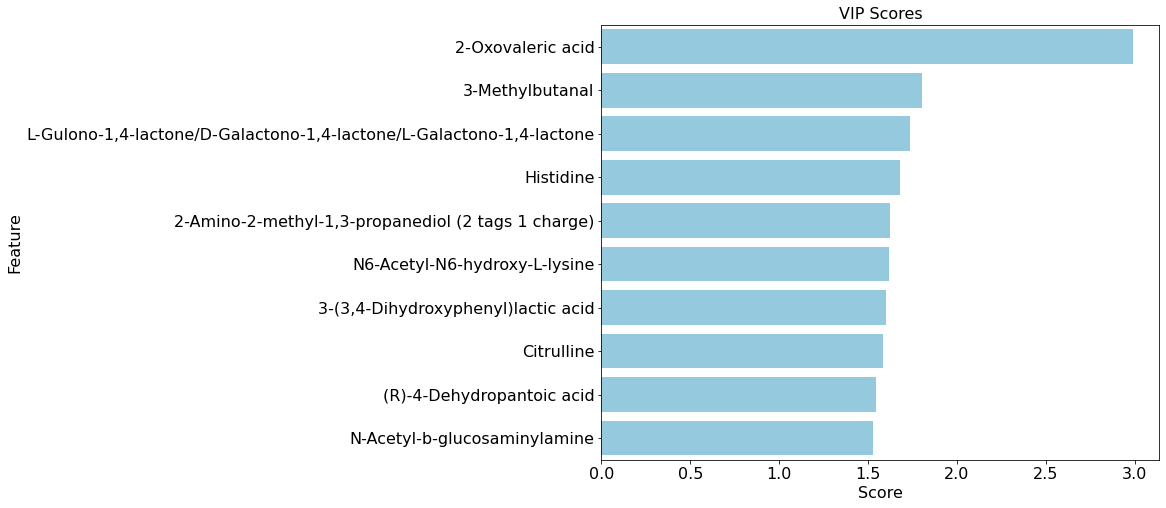

In [709]:
# Assume we have some feature names in a list
feature_names = df.columns[1:168]  # replace with your actual feature names

# Create a DataFrame for easier plotting
df_vip = pd.DataFrame({'Feature': feature_names, 'VIP': vip_scores})

# Sort by VIP score
df_vip = df_vip.sort_values('VIP', ascending=False).head(10)

# Create a horizontal bar plot (similar style to SHAP summary plot)
plt.figure(figsize=(10, 8))
sns.barplot(x='VIP', y='Feature', data=df_vip, orient='h', color='skyblue')
plt.title('VIP Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

### XGB for classificaiton

In [943]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.85
Permutation test p-value: 0.0099


### Fine-Tune model(XGB)

In [964]:
# Set up the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'min_child_weight':[1, 2, 3, 4, 5], 
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
    'max_depth':[1, 2, 3, 4, 5, None], 
    'n_estimators':[2, 25, 50, 75, 100]
    }

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# Save the model to disk
# filename = 'models/finalized_xgb_model.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Best Score: 0.93
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}


In [698]:
# Save the model to disk
filename = 'models/finalized_xgb_model_1.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Shap

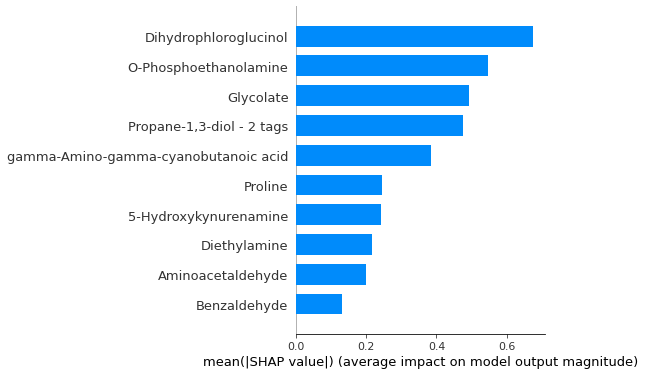

In [707]:
# Shap
# Load the model from disk
filename = 'models/finalized_xgb_model_1.sav'
best_model = pickle.load(open(filename, 'rb'))
# Train the model on your data
best_model.fit(x, y)

# Create a SHAP explainer object
explainer = shap.Explainer(best_model, x)

# Calculate the SHAP values for all the features
shap_values = explainer(x)

# Create a new figure before generating the summary plot
plt.figure()

# Create a summary plot of the SHAP values
shap.summary_plot(shap_values, x, max_display=10, plot_type='bar',show=False)

# Save the figure
#plt.savefig('figures/shap_summary_auto.png', bbox_inches='tight', dpi=300)

# Now display the plot
plt.show()

### Force plot

<Figure size 432x288 with 0 Axes>

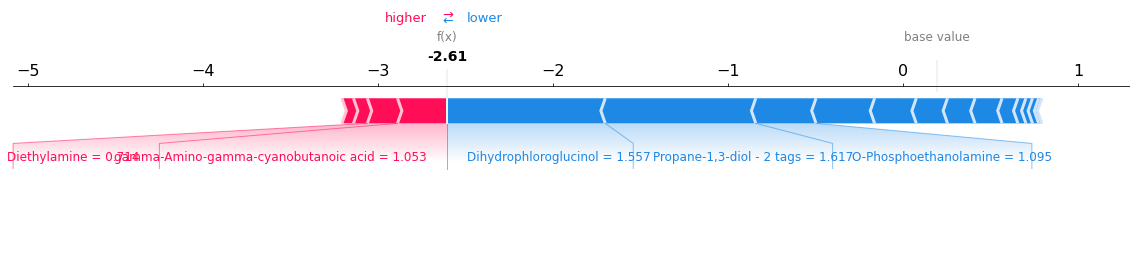

In [701]:
# Initialize JS visualization code
shap.initjs()

explainer = shap.TreeExplainer(best_model)

# Calculate the SHAP values for the data
shap_values = explainer.shap_values(x)

#  let's create a force plot for the first instance in the data
force_plot = shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

# Create a new figure
fig = plt.figure()

# Plot the SHAP force plot
shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[0, :],matplotlib=True, show=False)

# Save the figure
plt.savefig('figures/force_plot.png', bbox_inches='tight', dpi=300)

# # Show the SHAP force plot
# shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[0, :])


### Waterfall plot

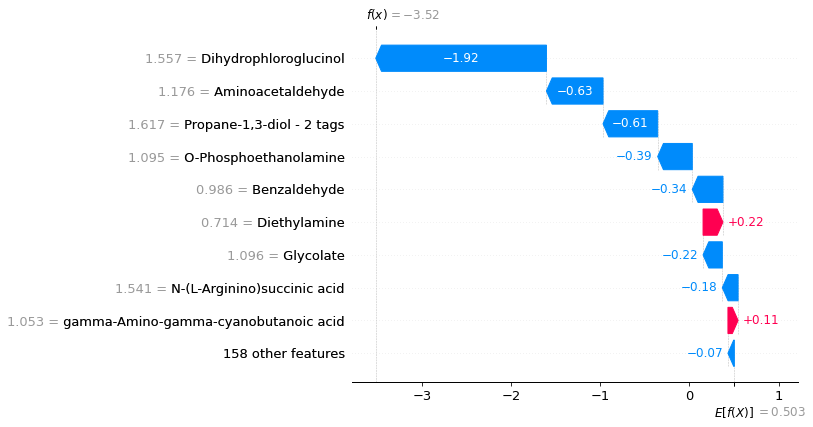

In [639]:

shap.initjs()

# Load the model from disk
filename = 'models/finalized_xgb_model.sav'
best_model = pickle.load(open(filename, 'rb'))
# Train the model on your data
best_model.fit(x, y)

# Create a SHAP explainer object
explainer = shap.Explainer(best_model, x)

# Calculate the SHAP values for all the features
shap_values = explainer(x)

# Create a new figure before generating the summary plot
fig, ax = plt.subplots()

# Create a summary plot of the SHAP values
shap.plots.waterfall(shap_values[0],show=True)

# Save the figure
fig.savefig('figures/waterfall.png', bbox_inches='tight', dpi=300)



### Scatter plot of Gini importance score

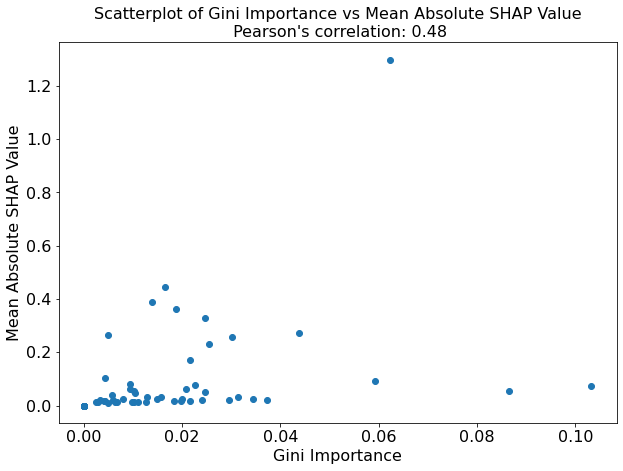

In [579]:
# Calculate Gini importance
gini_importance = best_model.feature_importances_

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values.values), axis=0)

# Calculate Pearson's correlation coefficient
corr, _ = pearsonr(gini_importance, mean_abs_shap_values)

# Create a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(gini_importance, mean_abs_shap_values)
plt.xlabel('Gini Importance')
plt.ylabel('Mean Absolute SHAP Value')
plt.title(f"Scatterplot of Gini Importance vs Mean Absolute SHAP Value\n Pearson's correlation: {corr:.2f}")
plt.show()

### GB for classificaiton

In [939]:
# Set up the Gradient Boosting classifier
model = GradientBoostingClassifier()

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.74
Permutation test p-value: 0.0099


### Fine-Tune Model(GB)

In [940]:
# Set up the Gradient Boosting classifier
model = GradientBoostingClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5],  
    'learning_rate': [0.1, 0.01, 0.001]  
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
GradientBoostingClassifier(max_depth=4)
Best Score: 0.80
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


### RF for classificaiton

In [936]:
# Set up the Random Forest classifier
model = RandomForestClassifier()

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.86
Permutation test p-value: 0.0099


### Fine-Tune for model(RF)

In [937]:
# Set up the Random Forest classifier
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# # Save the model to disk
# filename = 'models/finalized_rf_model_1.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=50)
Best Score: 0.90
Best Parameters:
{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [705]:
# # Save the model to disk
filename = 'models/finalized_rf_model_1.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Shap

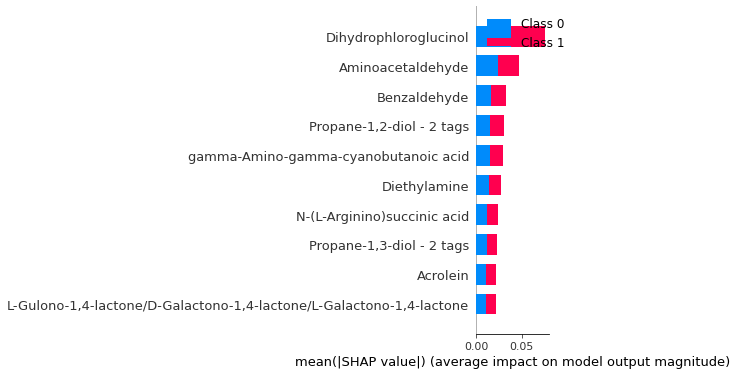

In [708]:
# Shap

# Load the model from disk
filename = 'models/finalized_rf_model_1.sav'
best_model = pickle.load(open(filename, 'rb'))

# Create a Tree explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for all of your data
shap_values = explainer.shap_values(x)

# Create a SHAP summary plot
shap.summary_plot(shap_values, x, max_display=10,plot_type="bar")

### Confusion matrix

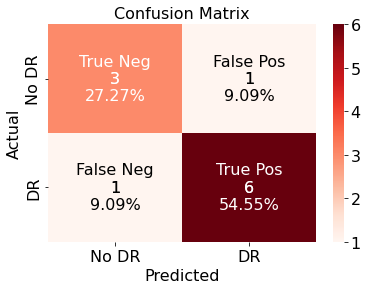

In [695]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train the random forest classifier
#rf_classifier = RandomForestClassifier()
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Assuming you have the confusion matrix 'cm' calculated
# Calculate the total number of samples
total_samples = np.sum(cm)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=True, xticklabels=['No DR', 'DR'], yticklabels=['No DR', 'DR'])

# Add labels, title, and axis ticks
tick_labels = ['No DR', 'DR']
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add values and percentages inside the cells
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if i == 0 and j == 0:
            label = f"True Neg\n{cm[i][j]:,}\n{cm[i][j] / total_samples:.2%}"
            color = 'white'  # Set color to white for True Neg
        elif i == 0 and j == 1:
            label = f"False Pos\n{cm[i][j]:,}\n{cm[i][j] / total_samples:.2%}"
            color = 'black'  # Set color to black for False Pos
        elif i == 1 and j == 0:
            label = f"False Neg\n{cm[i][j]:,}\n{cm[i][j] / total_samples:.2%}"
            color = 'black'  # Set color to black for False Neg
        else:
            label = f"True Pos\n{cm[i][j]:,}\n{cm[i][j] / total_samples:.2%}"
            color = 'white'  # Set color to white for True Pos
        plt.text(j + 0.5, i + 0.5, label, ha='center', va='center', color=color)

# Display the plot
plt.savefig('figures/cm.png',dpi=300)
plt.show()


### SVM for classificaiton

In [455]:
# Set up the SVM classifier
model = SVC()

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.69
Permutation test p-value: 0.0198


### Fine-Tune Model(SVM)

In [480]:
# Set up the SVC classifier
model = SVC()

# Define the parameter grid
param_grid = {
    'C': [1, 10, 100],  # Example values for C
    'kernel': ['linear', 'rbf'],  # Example values for kernel
    'gamma': [0.1, 1, 10],  # Example values for gamma
    'degree': [2, 3, 4],  # Example values for degree
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
SVC(C=1, degree=2, gamma=0.1, kernel='linear')
Best Score: 0.71
Best Parameters:
{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}


### Confusion matrix

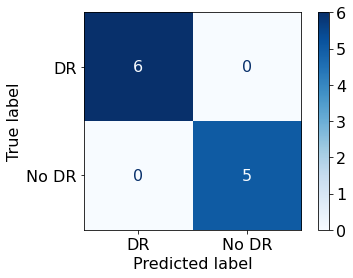

In [490]:
class_names = ['DR','No DR']
disp = plot_confusion_matrix(best_model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

#plt.savefig('cm.png',dpi=300)
plt.show()

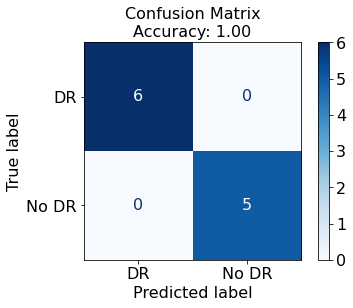

In [491]:
class_names = ['DR', 'No DR']

# Assuming you have already trained your model and have the predictions
predictions = model.predict(x_test)

# Display the confusion matrix
disp = plot_confusion_matrix(model, x_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None)  # Change normalize to 'true' or 'pred' for normalized confusion matrix

# Add accuracy value to the plot
disp.ax_.set_title("Confusion Matrix\nAccuracy: {:.2f}".format(accuracy_score(y_test, predictions)))

# Save the confusion matrix plot to a file (optional)
# plt.savefig('cm.png', dpi=300)

# Show the confusion matrix plot
plt.show()